# DS 6040: Baysian Machine Learning Course Project
# Exoplanet Classification
#### Authors:

In [1]:
# Setup
import numpy as np
import pandas as pd
import seaborn as sns
import pymc as pm
import arviz as az
from pymc import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xarray as xr
from scipy.special import expit as logistic
from datetime import datetime
from sklearn.metrics import ConfusionMatrixDisplay

path = 'C:/Users/jrkar/OneDrive/Documents/Schoolwork/DS6040 - Bayes/'
pd.set_option('display.max_columns', 500)

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data Vizualization

In [2]:
# Reading in data

nasa_data = pd.read_csv(path + 'cumulative.csv')
nasa_data.head(5)

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,q1_q17_dr25_tce,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,q1_q17_dr25_tce,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,q1_q17_dr25_tce,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


As we can see, there are a few fields which are categorical. For the first visualization of the data we will proceed to create a paired plot to show the relationships between the numeric variables. Because of this, we must remove the 

In [3]:
to_drop = ["rowid", "kepid", "kepoi_name", "kepler_name", "koi_teq_err1", "koi_teq_err2", "koi_tce_delivname"]
viz_data = nasa_data.drop(to_drop, axis = 1)

In [4]:
viz_data.head()

,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,93.59,29.45,-16.65,35.8,1.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,9.11,2.87,-1.62,25.8,2.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,39.30,31.04,-10.49,76.3,1.0,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,891.96,668.95,-230.35,505.6,1.0,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,926.16,874.33,-314.24,40.9,1.0,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [5]:
viz_data2 = viz_data[["koi_score", "koi_period", "koi_period_err1", "koi_period_err2"]]

In [6]:
viz_data2

,koi_score,koi_period,koi_period_err1,koi_period_err2
0,1.000,9.488036,2.775000e-05,-2.775000e-05
1,0.969,54.418383,2.479000e-04,-2.479000e-04
2,0.000,19.899140,1.494000e-05,-1.494000e-05
3,0.000,1.736952,2.630000e-07,-2.630000e-07
4,1.000,2.525592,3.761000e-06,-3.761000e-06
...,...,...,...,...
9559,0.000,8.589871,1.846000e-04,-1.846000e-04
9560,0.000,0.527699,1.160000e-07,-1.160000e-07
9561,0.497,1.739849,1.780000e-05,-1.780000e-05
9562,0.021,0.681402,2.434000e-06,-2.434000e-06


In [7]:
viz_data3 = viz_data2[:500]

In [8]:
viz_data3

,koi_score,koi_period,koi_period_err1,koi_period_err2
0,1.000,9.488036,2.775000e-05,-2.775000e-05
1,0.969,54.418383,2.479000e-04,-2.479000e-04
2,0.000,19.899140,1.494000e-05,-1.494000e-05
3,0.000,1.736952,2.630000e-07,-2.630000e-07
4,1.000,2.525592,3.761000e-06,-3.761000e-06
...,...,...,...,...
495,1.000,8.398430,5.660000e-05,-5.660000e-05
496,1.000,8.638474,3.522000e-05,-3.522000e-05
497,NaN,422.917678,9.327000e-03,-9.327000e-03
498,0.991,140.107650,1.870000e-03,-1.870000e-03


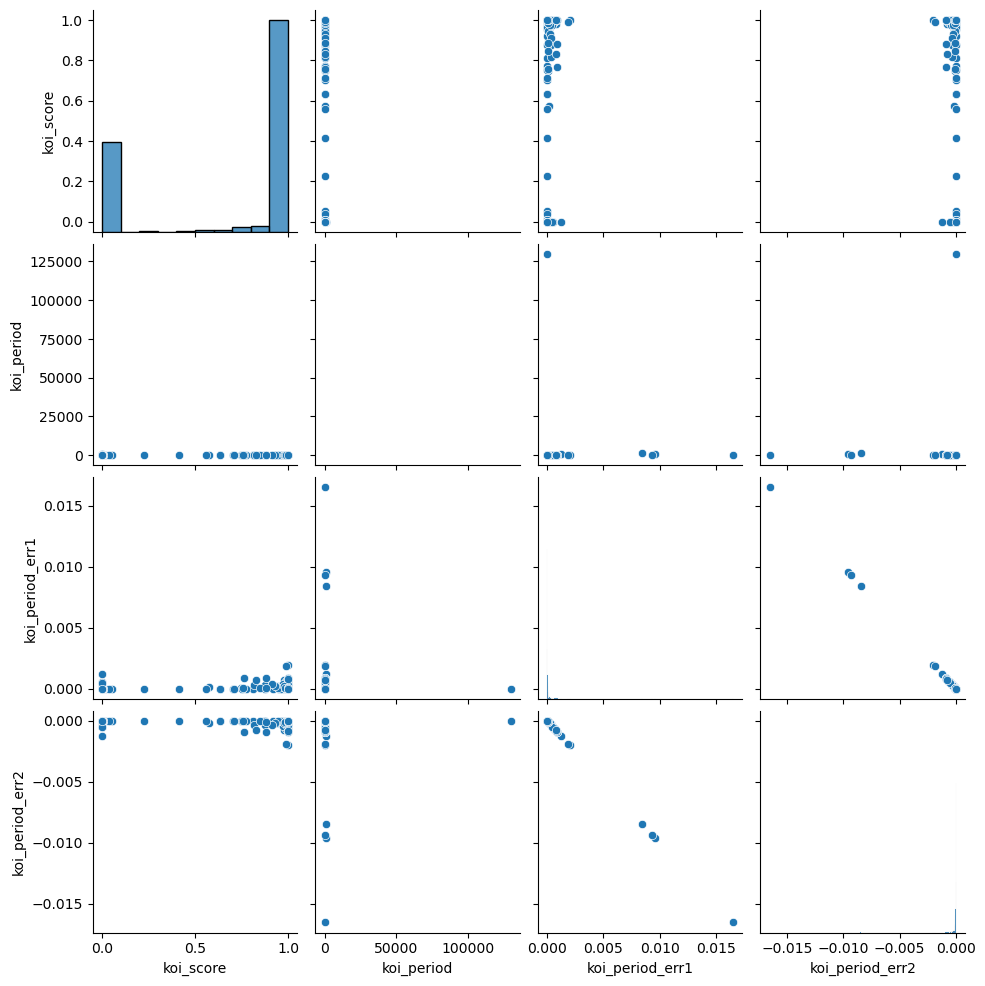

In [9]:
sns.pairplot(viz_data3)

### Cleaning

The data variables are split into categories on the NASA website. Underneath each catefory name we have entered the name of the list that contains the variable names belonging to this category.

KOI = "Kepler Object of Interest" <br>
KIC = "Kepler Input Catalog"

| Category | List Name | Description |
|:---------|:---------:|:------------|
|Identification Columns|id_vars|KOI Id and name|
|Exoplanet Archive Information|arch_vars|Archival records of KOI "dispositions" (classifications)|
|Project Disposition Columns|disp_vars|Kepler Project-informed "disposition" (classification) metadata|
|Transit Properties|tran_vars|Kepler Project derived features derived for classification assignment|
|Threshold-Crossing Event (TCE) Information|tce_vars|Features describing signal to noise ratio of measurements which are based on "planet transit" events.|
|Stellar Parameters|stel_vars|Describe star|
|KIC Parameters|kic_vars|Various brigtness measure of the star using differend bands in units of magnitude.|
|Pixel-Based KOI Vetting Statistics|pix_vars|Pixel level feature engineering to reduce transit false positives|

In [10]:
# Listing column names belonging to each category
id_vars = ["kepid", "kepoi_name"]

arch_vars = ["kepler_name", "koi_disposition", "koi_vet_stat", "koi_vet_date"]

disp_vars = ["koi_pdisposition", "koi_score", "koi_fpflag_nt",
             "koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec",
             "koi_disp_prov", "koi_comment"]

tran_vars = ["koi_period", "koi_time0bk", "koi_time0", "koi_eccen",
             "koi_longp", "koi_impact", "koi_duration", "koi_ingress",
             "koi_depth", "koi_ror", "koi_srho", "koi_fittype", 
             "koi_prad", "koi_sma", "koi_incl", "koi_teq", "koi_insol",
             "koi_dor", "koi_limbdark_mod", "koi_ldm_coeff1",
             "koi_ldm_coeff2", "koi_ldm_coeff3", "koi_ldm_coeff4",
             "koi_parm_prov"]

tce_vars = ["koi_max_sngle_ev", "koi_max_mult_ev", "koi_model_snr",
            "koi_count", "koi_num_transits", "koi_tce_plnt_num",
            "koi_tce_delivname", "koi_quarters", "koi_trans_mod",
            "koi_model_dof", "koi_model_chisq", "koi_datalink_dvr",
            "koi_datalink_dvs"]

stel_vars = ["koi_steff", "koi_slogg", "koi_smet", "koi_srad",
             "koi_smass", "koi_sage", "koi_sparprov"]

kic_vars = ["ra", "dec", "koi_kepmag", "koi_gmag", "koi_rmag",
            "koi_imag", "koi_zmag", "koi_jmag", "koi_hmag", "koi_kmag"]

pix_vars = ["koi_fwm_sra", "koi_fwm_sdec", "koi_fwm_sdec", 
            "koi_fwm_srao", "koi_fwm_sdeco", "koi_fwm_prao",
            "koi_fwm_pdeco", "koi_fwm_stat_sig", "koi_dicco_mra",
            "koi_dicco_mdec", "koi_dicco_msky", "koi_dikco_mra",
            "koi_dikco_mdec", "koi_dikco_msky"]

## Model Building

In [11]:
replace_map = {'CANDIDATE':1, 'FALSE POSITIVE':0}

nasa_data.koi_pdisposition=nasa_data.koi_pdisposition.map(replace_map)

In [12]:
#Removing koi_tce_delivname, "koi_tce_plnt_num"
data_vars = ["koi_max_sngle_ev", "koi_max_mult_ev", "koi_model_snr",
            "koi_count", "koi_num_transits",
            "koi_quarters", "koi_trans_mod",
            "koi_model_dof", "koi_model_chisq", "koi_datalink_dvr",
            "koi_datalink_dvs", "koi_steff", "koi_slogg", "koi_smet", "koi_srad",
             "koi_smass", "koi_sage", "koi_sparprov", "ra", "dec", "koi_kepmag", "koi_gmag", "koi_rmag",
            "koi_imag", "koi_zmag", "koi_jmag", "koi_hmag", "koi_kmag", "koi_fwm_sra", "koi_fwm_sdec", "koi_fwm_sdec", 
            "koi_fwm_srao", "koi_fwm_sdeco", "koi_fwm_prao",
            "koi_fwm_pdeco", "koi_fwm_stat_sig", "koi_dicco_mra",
            "koi_dicco_mdec", "koi_dicco_msky", "koi_dikco_mra",
            "koi_dikco_mdec", "koi_dikco_msky"]

x = [col for col in nasa_data.columns if col in data_vars]
y = [col for col in nasa_data.columns if col in tran_vars]

nasa_standard = nasa_data

X = nasa_standard[x]
mean = X.mean()
std = X.std()
X = (X-mean)/std
X['koi_pdisposition'] = nasa_data.koi_pdisposition

In [13]:
X
XD = X.dropna()
XD

,koi_model_snr,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag,koi_pdisposition
0,-0.281595,-0.316020,0.362554,-0.130845,-0.026420,1.202701,0.781259,1
1,-0.294161,-0.316020,0.362554,-0.130845,-0.026420,1.202701,0.781259,1
2,-0.230703,0.183441,0.540545,-0.140474,1.037343,1.200612,0.845498,0
3,0.308750,0.123205,0.586777,-0.153041,-1.369000,1.242565,0.961706,0
4,-0.275186,0.406819,0.295519,-0.111423,-0.693417,1.226179,0.898189,1
...,...,...,...,...,...,...,...,...
9559,-0.316025,-0.086368,-0.032724,-0.104569,1.403299,0.878285,0.154025,0
9560,0.243030,-0.086368,0.505872,-0.134762,1.075929,0.911737,-0.131803,0
9561,-0.313261,0.517252,0.309388,-0.113871,-1.164504,0.931008,0.355404,1
9562,-0.311125,0.585019,0.316323,-0.112239,0.441552,0.934635,0.808687,0


In [14]:
Y = XD.koi_pdisposition
X = XD[x]

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, shuffle=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 132 seconds.


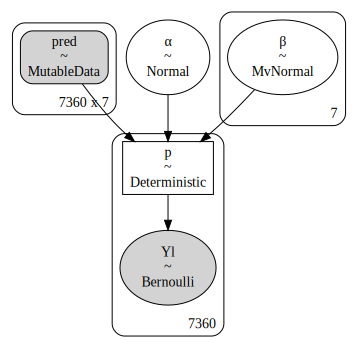

In [16]:
# Matrix version of the model

with pm.Model() as logistic_model:
    Y = Y_train
    X = pm.MutableData('pred', X_train)
    k =  X_train.shape[1]
    α = pm.Normal('α', mu=0, sigma=100)
    # Beta coefficients for predictor variables & priors
    β = pm.MvNormal('β', mu=np.zeros(k), cov=100*np.eye(k), shape=k)
    #β = pm.MvNormal('β', mu=np.zeros(k), cov=100*np.eye(k), shape=k)
    μ = α + pm.math.dot(X,β)
    p = pm.Deterministic('p',  pm.invlogit(μ))
    # Model error
    #sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)

    Yl = pm.Bernoulli('Yl', p=p, observed=Y)
    #Yl = pm.Normal('Yl', mu=μ, sd=sigma_y, observed=Y)
    binout = pm.sample(1000, tune=2000) #init="adapt_diag"
    
pm.model_to_graphviz(logistic_model)
#logistic_model.check_test_point()
#Xlog = 1/(1+np.exp(-1*X))
#Xlog

### Model Information and Vizualization

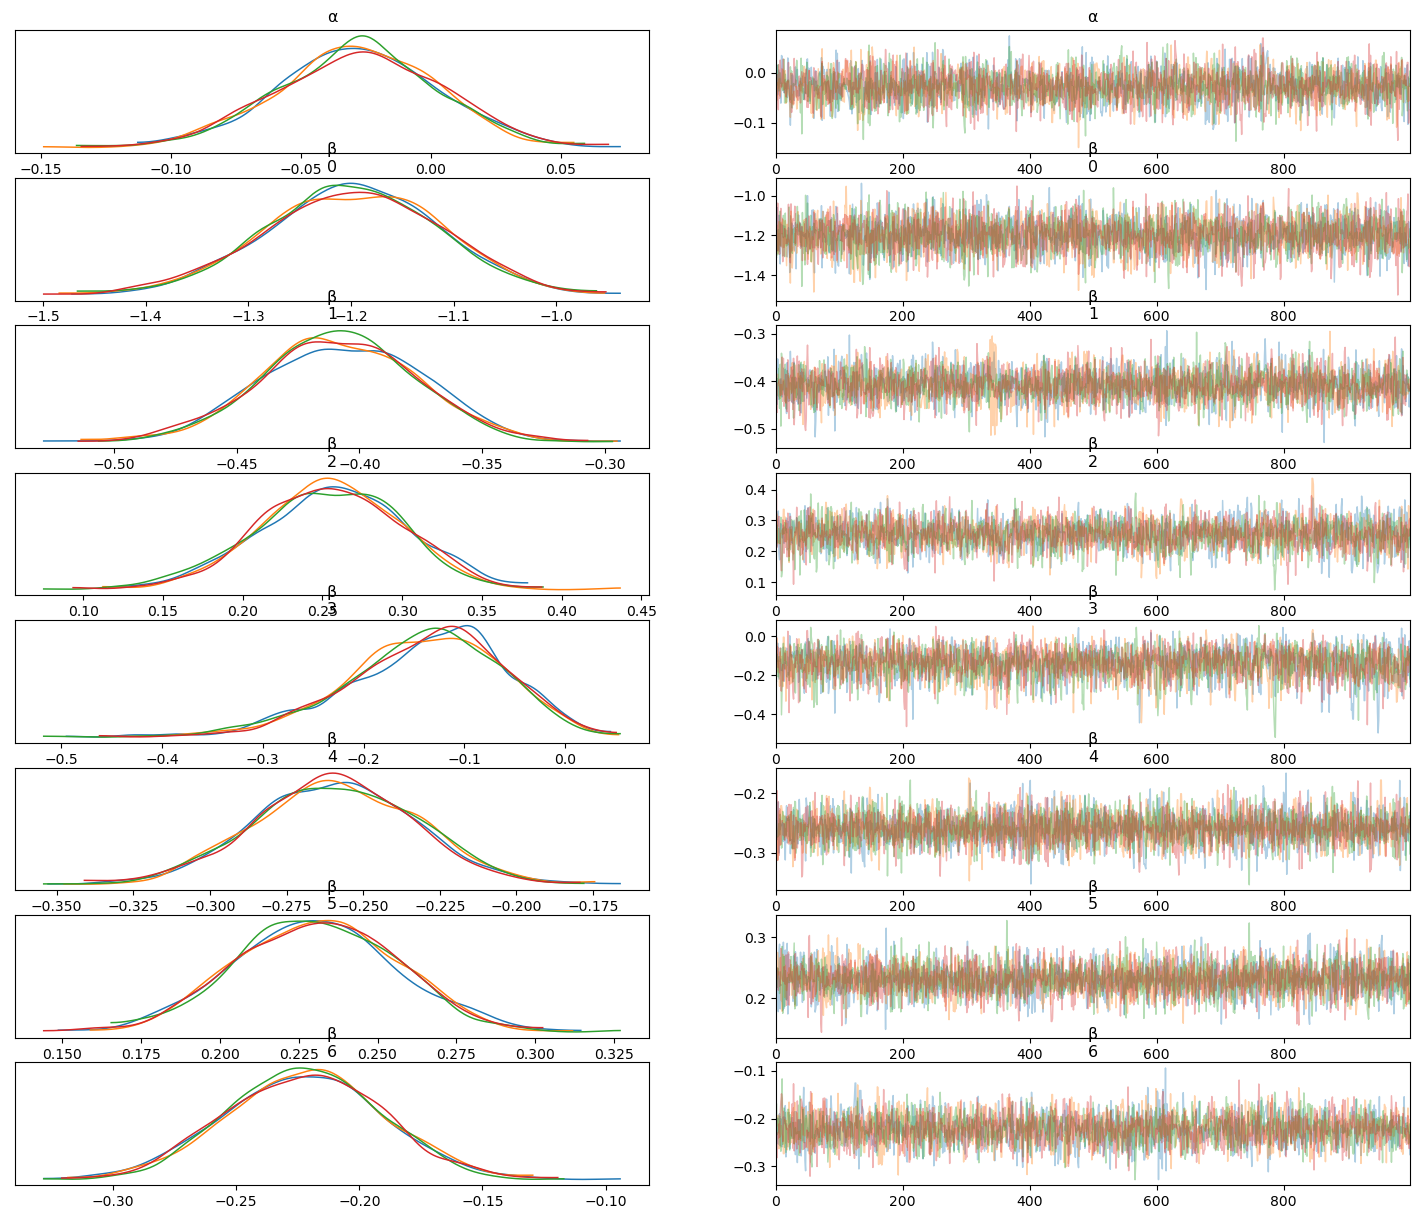

In [17]:
#Traceplots
az.plot_trace(binout, compact = False, var_names = ['α','β'], figsize = (18,15));

In [18]:
# summary statistics on the posterior distributions

az.summary(binout, var_names = ['α', 'β'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.028,0.031,-0.084,0.031,0.000,0.000,4423.0,2931.0,1.0
β[0],-1.199,0.084,-1.365,-1.050,0.001,0.001,4801.0,3296.0,1.0
β[1],-0.408,0.032,-0.468,-0.349,0.000,0.000,4734.0,3102.0,1.0
β[2],0.255,0.046,0.170,0.340,0.001,0.001,3239.0,2793.0,1.0
β[3],-0.140,0.078,-0.287,-0.003,0.001,0.001,3470.0,2680.0,1.0
β[4],-0.259,0.026,-0.310,-0.212,0.000,0.000,6007.0,2925.0,1.0
β[5],0.231,0.025,0.183,0.277,0.000,0.000,5967.0,2875.0,1.0
β[6],-0.222,0.031,-0.278,-0.162,0.000,0.000,3930.0,2595.0,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

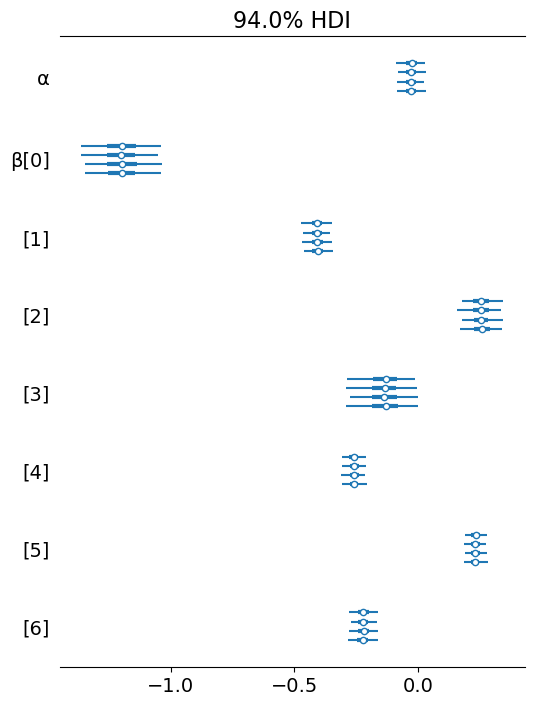

In [19]:
#Forest Plot
az.plot_forest(binout, var_names=['α', 'β'])

c:\Users\jrkar\anaconda3\envs\pymc_env\lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (7368) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'β\n0'}>,
        <AxesSubplot:title={'center':'β\n1'}>,
        <AxesSubplot:title={'center':'β\n2'}>],
       [<AxesSubplot:title={'center':'β\n3'}>,
        <AxesSubplot:title={'center':'β\n4'}>,
        <AxesSubplot:title={'center':'β\n5'}>,
        <AxesSubplot:title={'center':'β\n6'}>],
       [<AxesSubplot:title={'center':'p\n0'}>,
        <AxesSubplot:title={'center':'p\n1'}>,
        <AxesSubplot:title={'center':'p\n2'}>,
        <AxesSubplot:title={'center':'p\n3'}>],
       [<AxesSubplot:title={'center':'p\n4'}>,
        <AxesSubplot:title={'center':'p\n5'}>,
        <AxesSubplot:title={'center':'p\n6'}>,
        <AxesSubplot:title={'center':'p\n7'}>],
       [<AxesSubplot:title={'center':'p\n8'}>,
        <AxesSubplot:title={'center':'p\n9'}>,
        <AxesSubplot:title={'center':'p\n10'}>,
        <AxesSubplot:title={'center':'p\n11'}>],
       [<AxesSubplot:title={'center':'p\n12'}>,
        

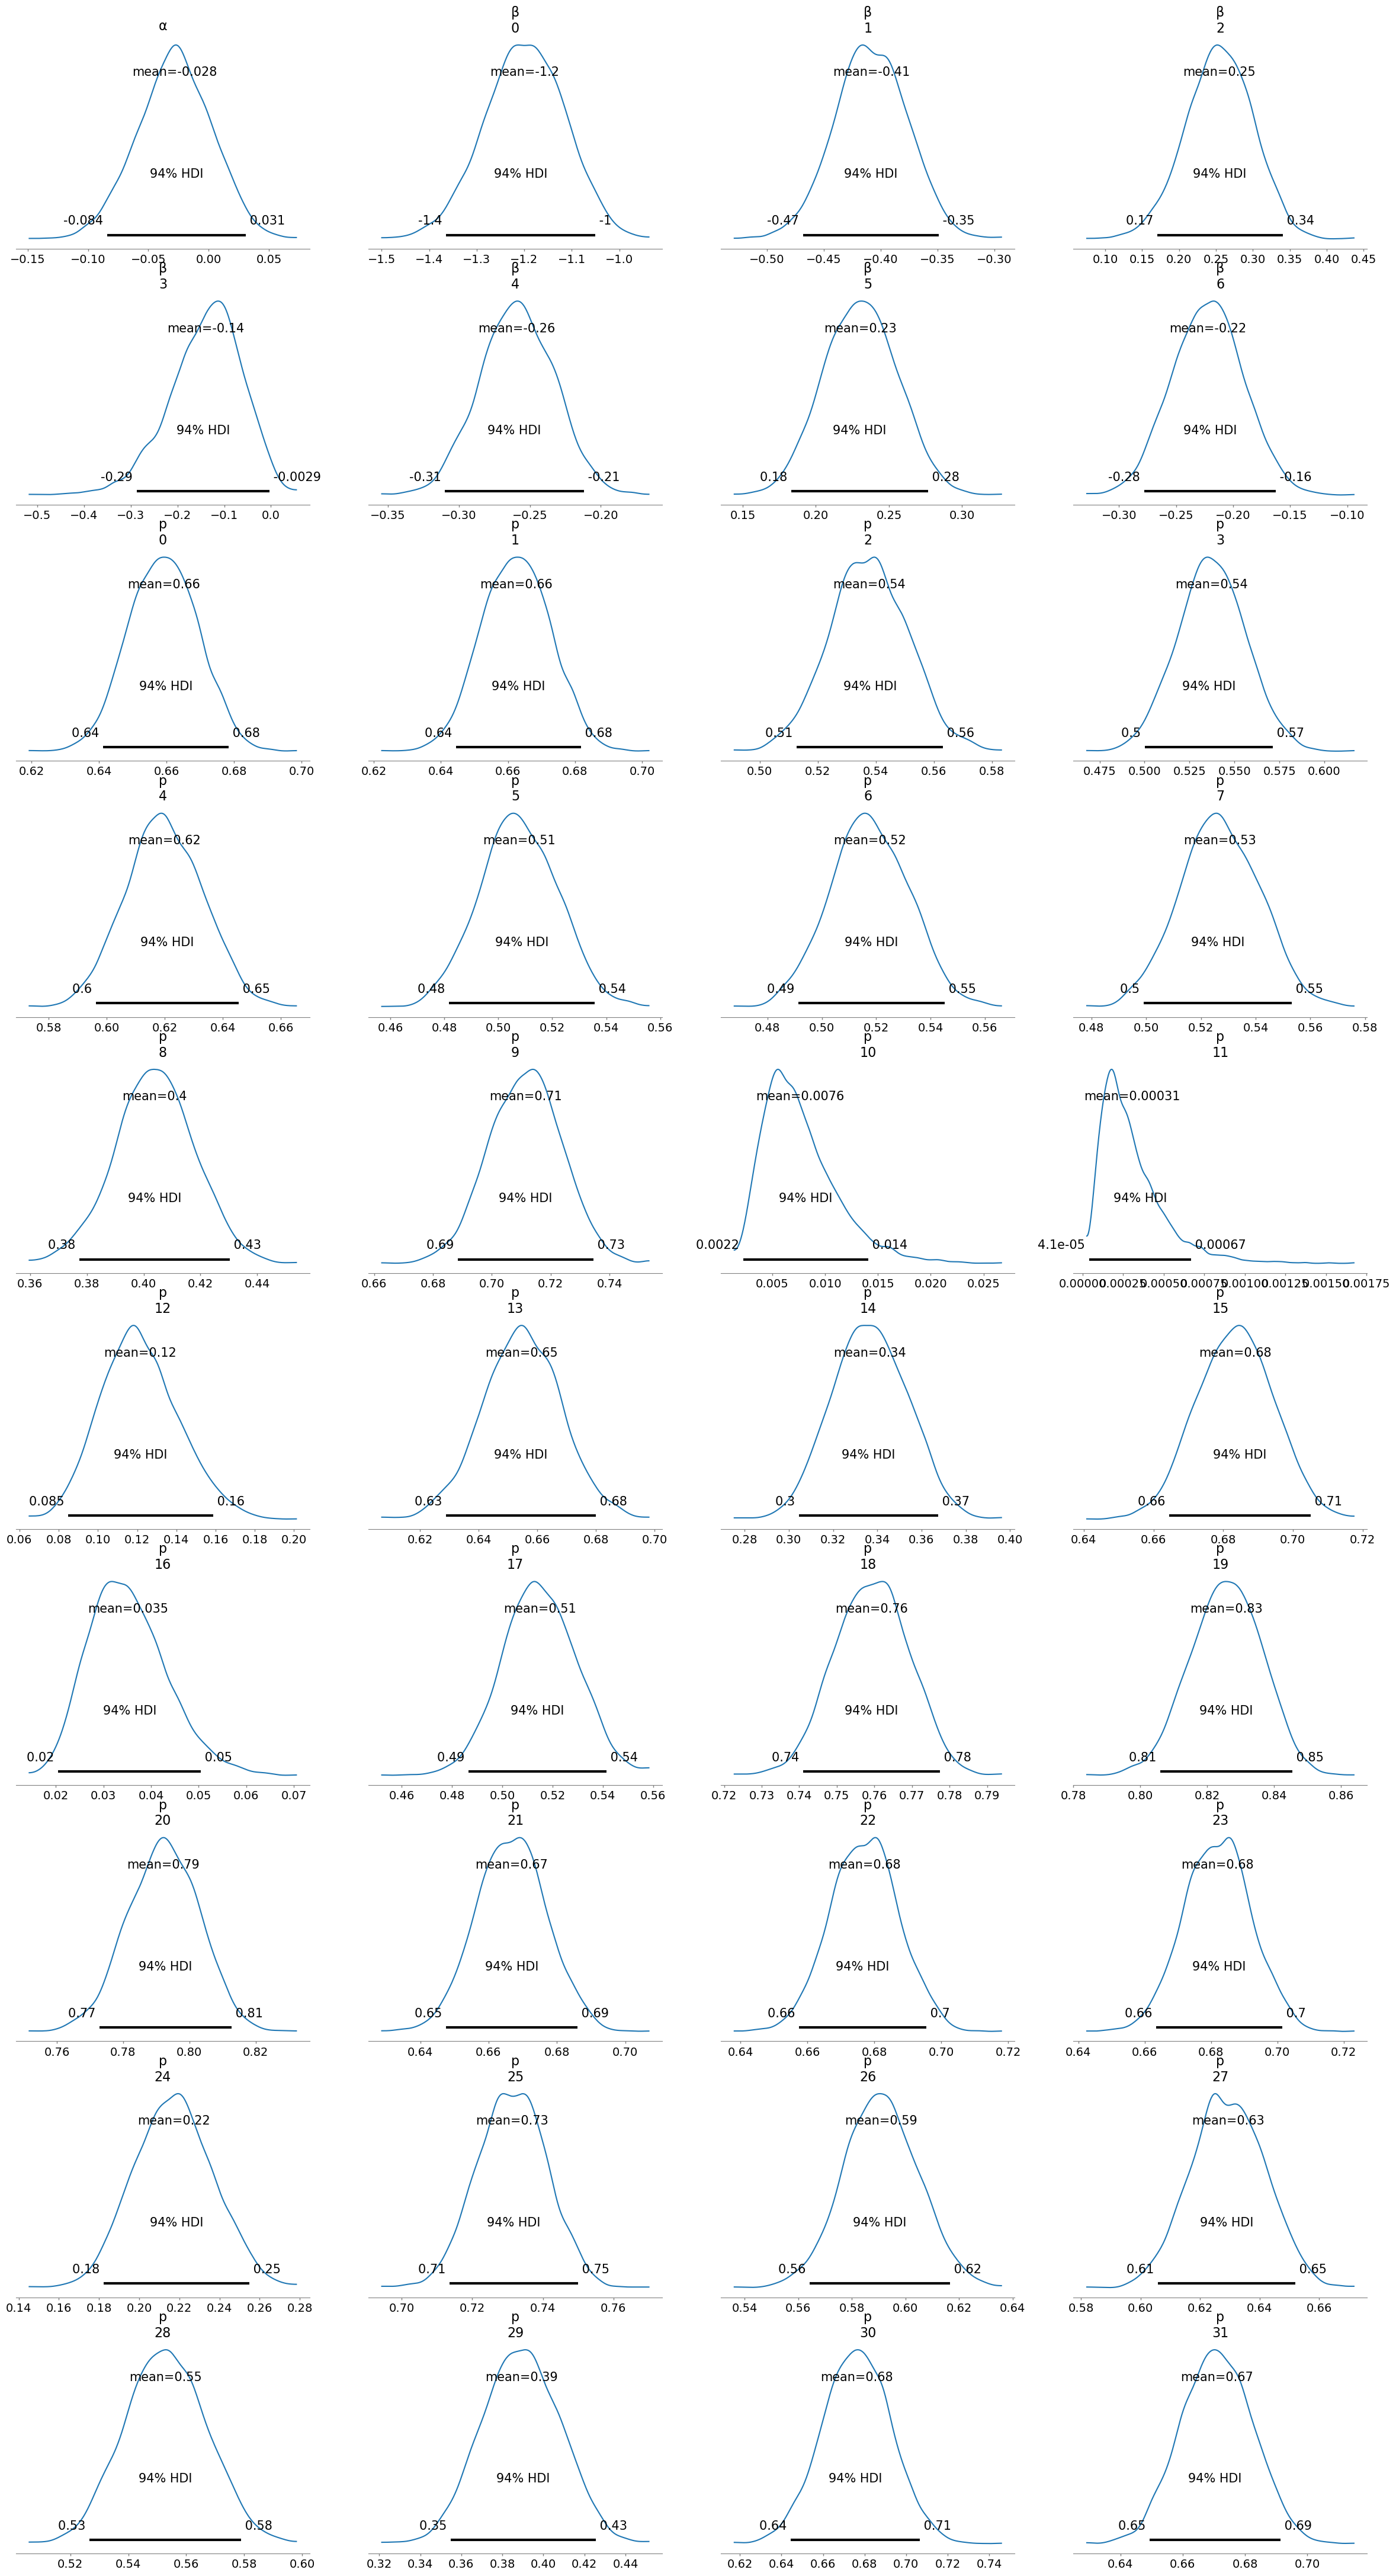

In [20]:
#Parameter Posteriors
az.plot_posterior(binout)

Sampling: [Yl]


<AxesSubplot:xlabel='Yl / Yl'>

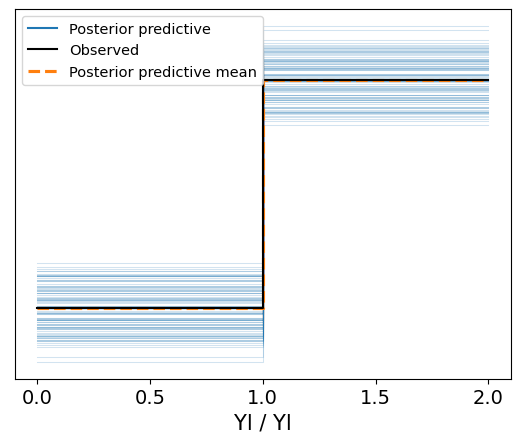

In [21]:
with logistic_model:
    ppc = pm.sample_posterior_predictive(binout, extend_inferencedata=True)

#Posterior Predictive Distribution
az.plot_ppc(binout, num_pp_samples=(100))

In [22]:
#Prediction

predictors_out_of_sample = X_test
outcomes_out_of_sample = Y_test

with logistic_model:
    # update values of predictors:
    pm.set_data({"pred": predictors_out_of_sample})
    # use the updated values and predict outcomes and probabilities:
    binout2 = pm.sample_posterior_predictive(
        binout,
        var_names=["p"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
    )

Sampling: []


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


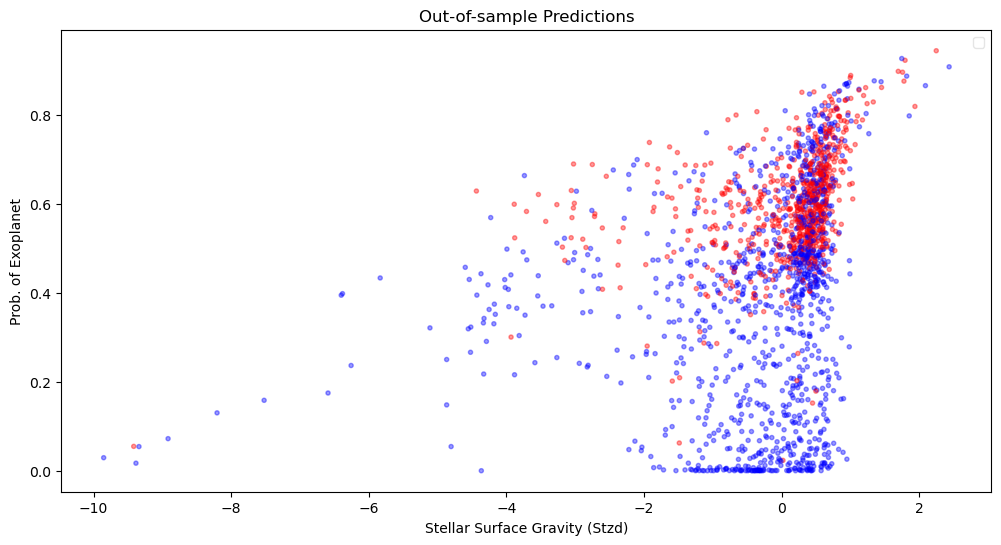

In [23]:
_, ax = plt.subplots(figsize=(12, 6))

preds_out_of_sample = binout2.predictions_constant_data["pred"][:, 2]#.sortby("pred")
model_preds = binout2.predictions.mean(("chain", "draw"))
cat = np.where(model_preds.p>=0.5,1,0)
col = []
rate = []

mark = np.where(model_preds.p>=0.5,'b','x')

for i in range(cat.size):
    if cat[i] == Y_test.tolist()[i]:
        col.append('b')
        rate.append(1)
    else:
        col.append('r')
        rate.append(0)

ax.scatter(x = preds_out_of_sample, 
           y = model_preds.p,
           color = col,
           marker = '.',
           alpha = 0.4,
           )

ax.set_xlabel("Stellar Surface Gravity (Stzd)")
ax.set_ylabel("Prob. of Exoplanet")
ax.set_title("Out-of-sample Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5);

In [24]:
print("Prediction Rate: " + str(sum(rate)/len(rate)))

Prediction Rate: 0.6021739130434782


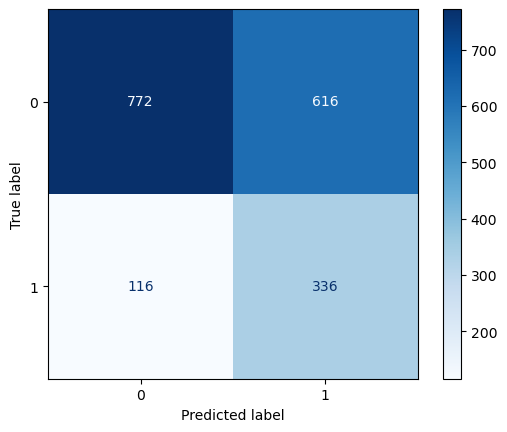

In [25]:
#Generate confusion matrix
ConfusionMatrixDisplay.from_predictions(Y_test.to_list(), cat, cmap="Blues")
plt.show()

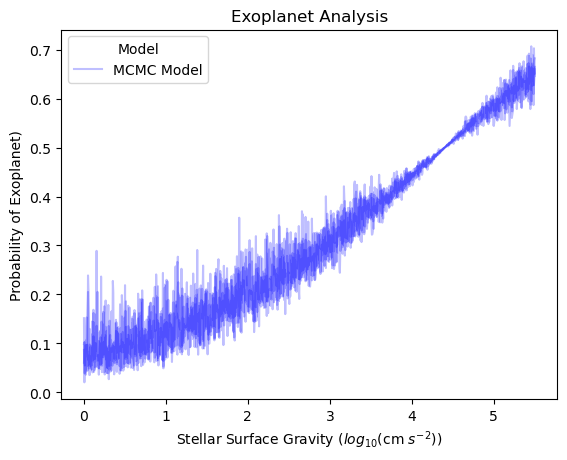

In [26]:
with logistic_model:
    pm.set_data({"pred": X_train})

# Plot of the model
# models = ['main','simple']
colors = ['blue', 'green']
shape = binout.posterior['α'].shape
x = np.linspace(-10, 2.5, shape[1])
x = np.array(x)
z = np.broadcast_to(x, shape)
Age = np.linspace(0,5.5, shape[1])

main_post = 1/(1 + np.exp(-binout.posterior['β'][:,:,2]*z))
out =[]
for i in range(4):
    out.append(main_post[i,:])
    if i == 0:
        plt.plot(Age,out[i], color = 'blue', label = 'MCMC Model', alpha = .25)
    else:
        plt.plot(Age,out[i], color = 'blue',alpha = .25)

plt.title("Exoplanet Analysis")
plt.xlabel("Stellar Surface Gravity ($log_{10}$(cm $s^{-2}$))") 
plt.ylabel("Probability of Exoplanet)")#, title="Binomial regression")
plt.legend(title ="Model")

### ADVI Version

In [27]:
with logistic_model:
    # update values of predictors:
    pm.set_data({"pred": X_train})

In [28]:
t0 = datetime.now()
advi_fit_pp = pm.fit(10000, method='advi', model=logistic_model)
t1 = datetime.now()

Finished [100%]: Average Loss = 4,685.2


In [29]:
print("Optimization finished in: " + str(t1-t0) + " seconds")

Optimization finished in: 0:00:46.704869 seconds


### ADVI Model Information and Visualization

In [30]:
advi_pp_trace = advi_fit_pp.sample(10000)

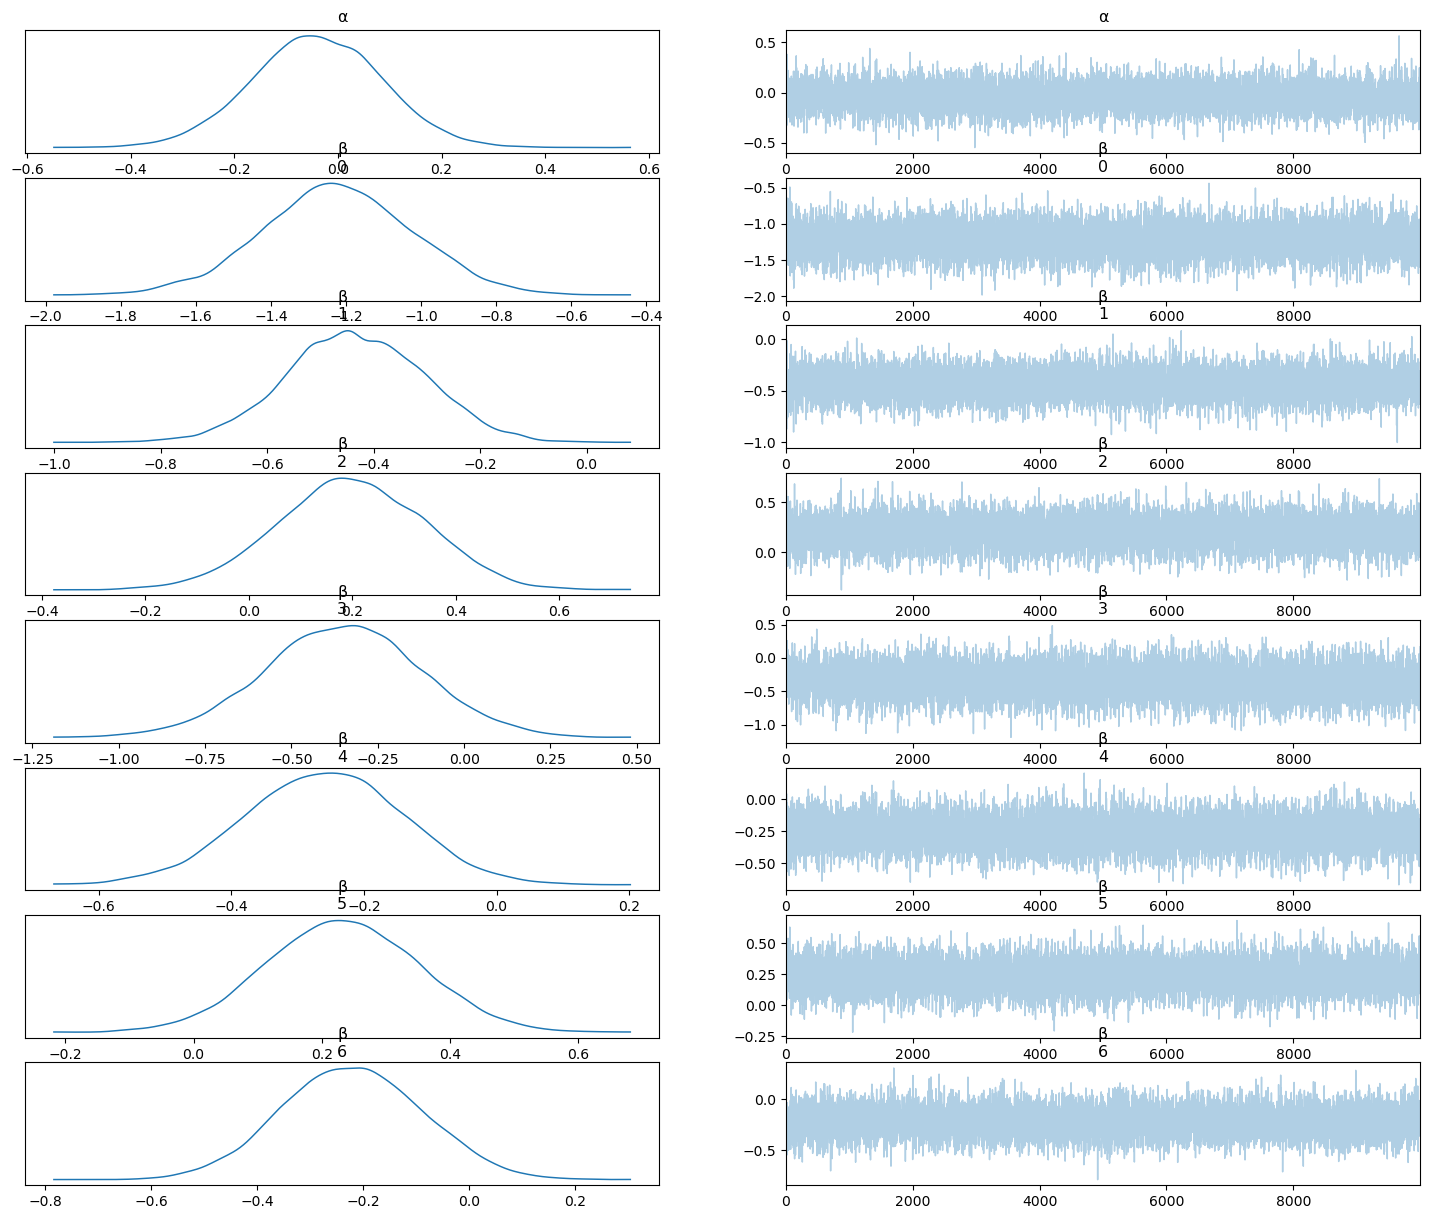

In [31]:
#Traceplots
az.plot_trace(advi_pp_trace, compact = False, var_names = ['α','β'], figsize = (18,15));

In [32]:
# summary statistics on the posterior distributions

az.summary(advi_pp_trace, var_names = ['α', 'β'])

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.042,0.126,-0.280,0.192,0.001,0.001,9936.0,9877.0,NaN
β[0],-1.225,0.201,-1.614,-0.850,0.002,0.001,9928.0,9971.0,NaN
β[1],-0.434,0.131,-0.681,-0.193,0.001,0.001,10364.0,9798.0,NaN
β[2],0.197,0.143,-0.073,0.461,0.001,0.001,9968.0,9797.0,NaN
β[3],-0.354,0.227,-0.789,0.069,0.002,0.002,9395.0,9173.0,NaN
β[4],-0.260,0.120,-0.482,-0.031,0.001,0.001,10258.0,9569.0,NaN
β[5],0.233,0.119,0.003,0.448,0.001,0.001,9468.0,9716.0,NaN
β[6],-0.222,0.133,-0.469,0.028,0.001,0.001,9937.0,9600.0,NaN


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

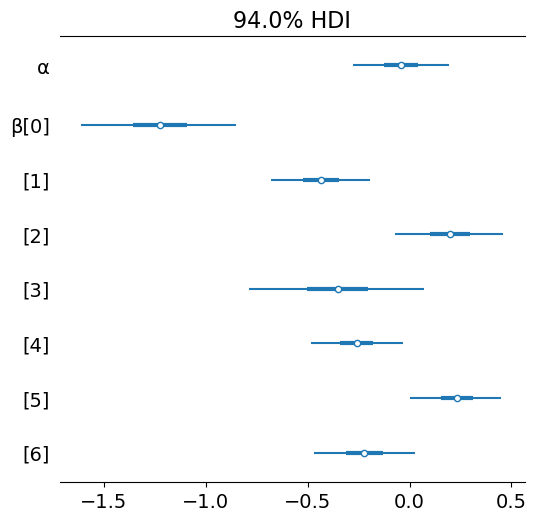

In [33]:
#Forest Plot
az.plot_forest(advi_pp_trace, var_names=['α', 'β'])

c:\Users\jrkar\anaconda3\envs\pymc_env\lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (7368) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'β\n0'}>,
        <AxesSubplot:title={'center':'β\n1'}>,
        <AxesSubplot:title={'center':'β\n2'}>],
       [<AxesSubplot:title={'center':'β\n3'}>,
        <AxesSubplot:title={'center':'β\n4'}>,
        <AxesSubplot:title={'center':'β\n5'}>,
        <AxesSubplot:title={'center':'β\n6'}>],
       [<AxesSubplot:title={'center':'p\n0'}>,
        <AxesSubplot:title={'center':'p\n1'}>,
        <AxesSubplot:title={'center':'p\n2'}>,
        <AxesSubplot:title={'center':'p\n3'}>],
       [<AxesSubplot:title={'center':'p\n4'}>,
        <AxesSubplot:title={'center':'p\n5'}>,
        <AxesSubplot:title={'center':'p\n6'}>,
        <AxesSubplot:title={'center':'p\n7'}>],
       [<AxesSubplot:title={'center':'p\n8'}>,
        <AxesSubplot:title={'center':'p\n9'}>,
        <AxesSubplot:title={'center':'p\n10'}>,
        <AxesSubplot:title={'center':'p\n11'}>],
       [<AxesSubplot:title={'center':'p\n12'}>,
        

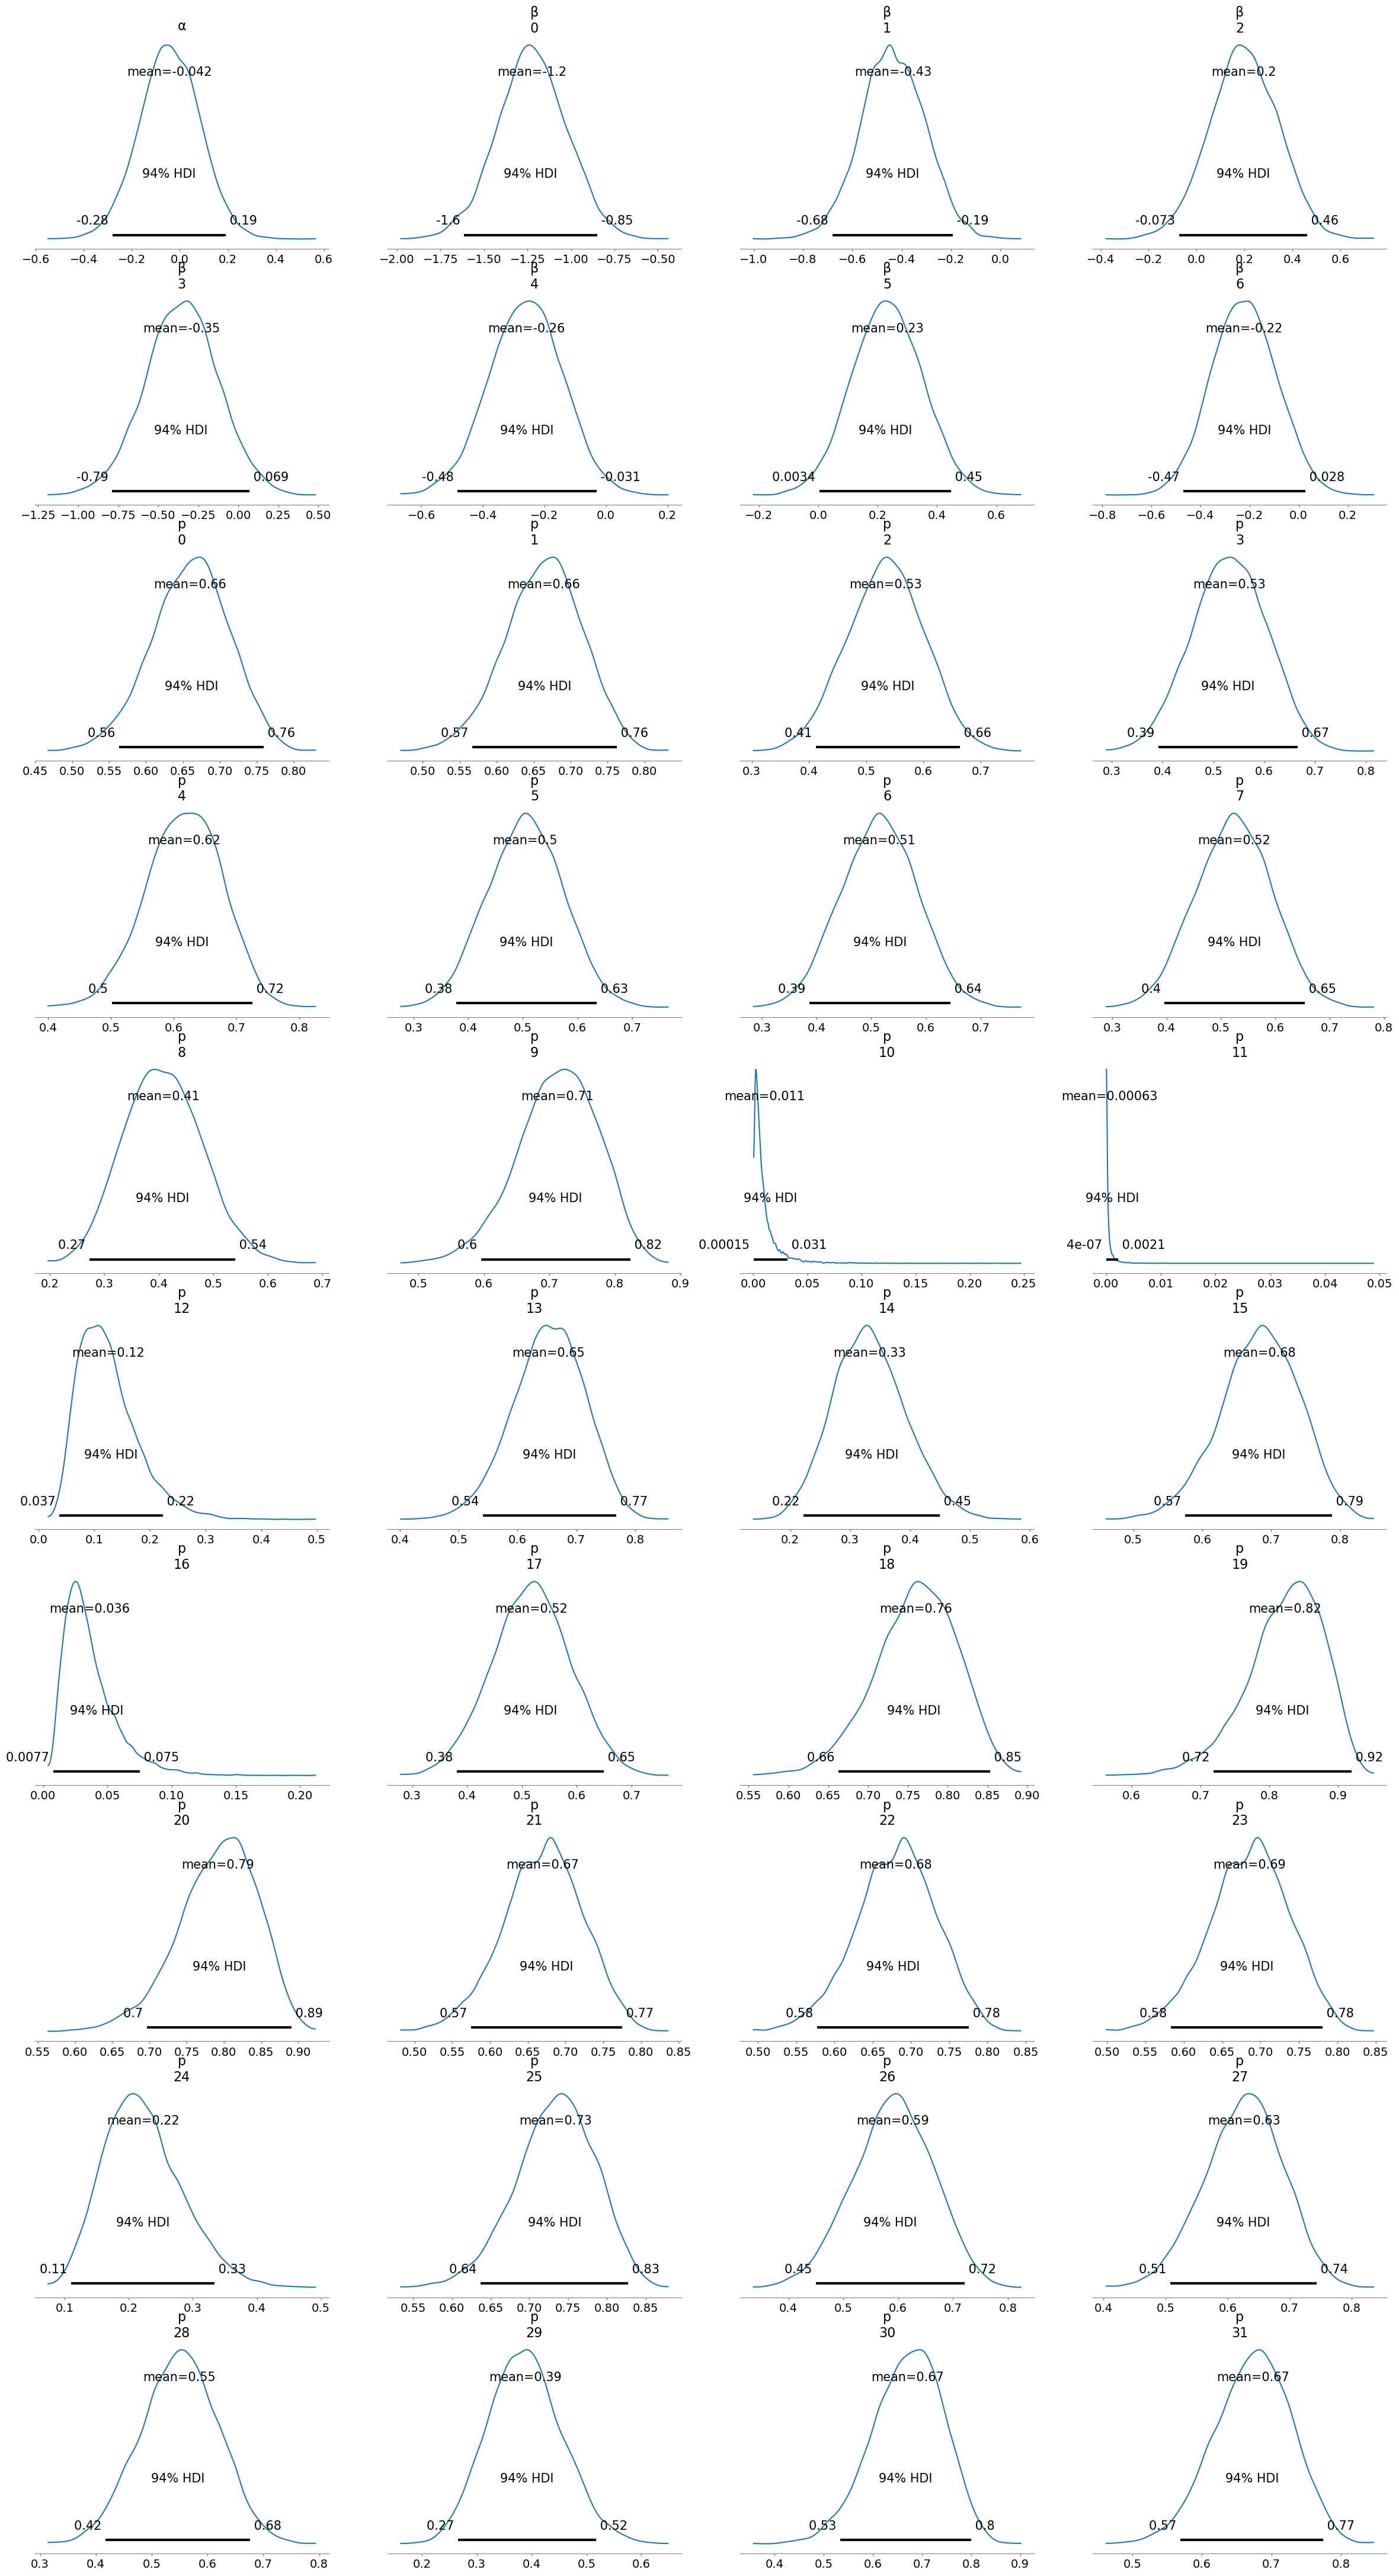

In [34]:
#Parameter Posteriors
az.plot_posterior(advi_pp_trace)

Sampling: [Yl]


<AxesSubplot:xlabel='Yl / Yl'>

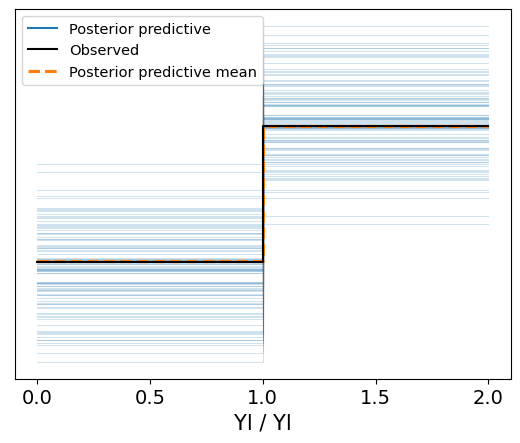

In [35]:
with logistic_model:
    ppc = pm.sample_posterior_predictive(advi_pp_trace, extend_inferencedata=True)

#Posterior Predictive Distribution
az.plot_ppc(advi_pp_trace, num_pp_samples=(100))

In [36]:
#Predictions

predictors_out_of_sample = X_test
outcomes_out_of_sample = Y_test

with logistic_model:
    # update values of predictors:
    pm.set_data({"pred": predictors_out_of_sample})
    # use the updated values and predict outcomes and probabilities:
    advi_pp_trace2 = pm.sample_posterior_predictive(
        advi_pp_trace,
        var_names=["p"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
    )

Sampling: []


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


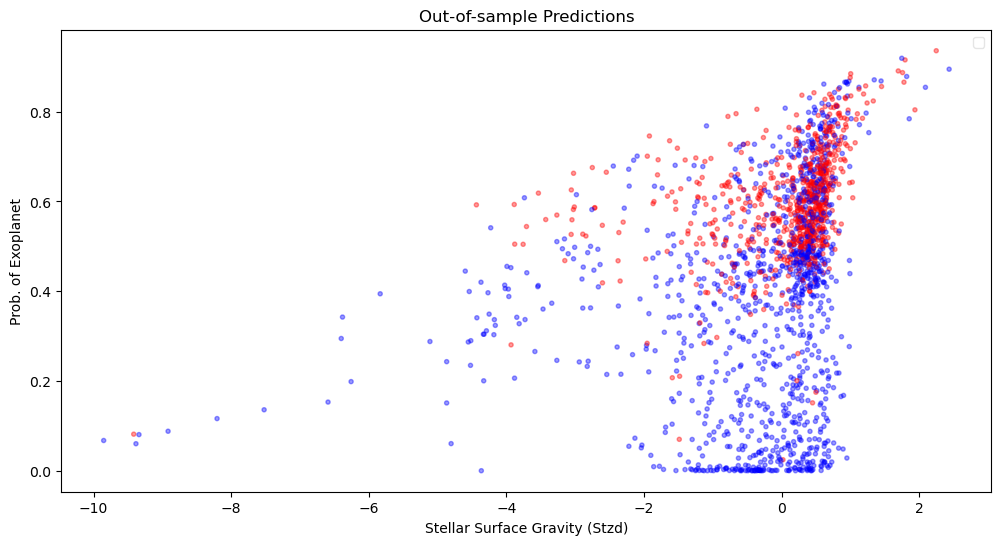

In [37]:
_, ax = plt.subplots(figsize=(12, 6))

preds_out_of_sample = advi_pp_trace2.predictions_constant_data["pred"][:, 2]#.sortby("pred")
model_preds = advi_pp_trace2.predictions.mean(("chain", "draw"))
cat = np.where(model_preds.p>=0.5,1,0)
col = []
rate = []

mark = np.where(model_preds.p>=0.5,'b','x')

for i in range(cat.size):
    if cat[i] == Y_test.tolist()[i]:
        col.append('b')
        rate.append(1)
    else:
        col.append('r')
        rate.append(0)


ax.scatter(x = preds_out_of_sample, 
           y = model_preds.p,
           color = col,
           marker = '.',
           alpha=0.4
           )

ax.set_xlabel("Stellar Surface Gravity (Stzd)")
ax.set_ylabel("Prob. of Exoplanet")
ax.set_title("Out-of-sample Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5);

In [38]:
print("Prediction Rate: " + str(sum(rate)/len(rate)))

Prediction Rate: 0.6010869565217392


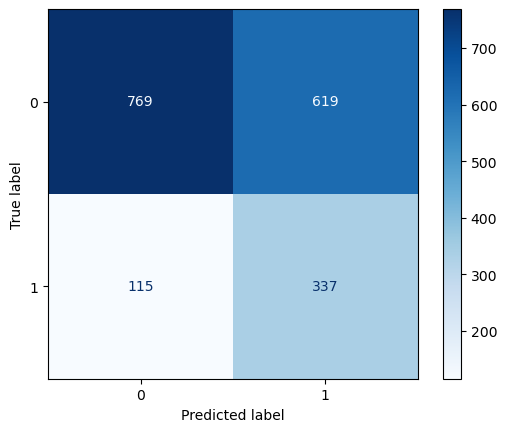

In [39]:
#Generate confusion matrix
ConfusionMatrixDisplay.from_predictions(Y_test.to_list(), cat, cmap="Blues")
plt.show()

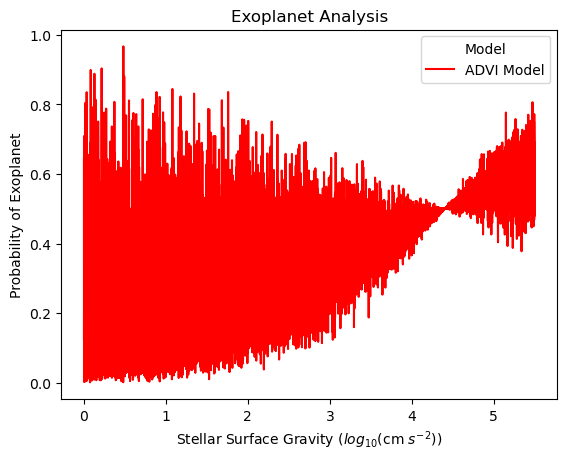

In [40]:
with logistic_model:
    pm.set_data({"pred": predictors_out_of_sample})

# Plot of the model

# models = ['main','simple']
colors = ['blue', 'green']
shape = advi_pp_trace.posterior['α'].shape
x = np.linspace(-10, 2.5, shape[1])
x = np.array(x)
z = np.broadcast_to(x, shape)
Age = np.linspace(0,5.5, shape[1])

main_post2 = 1/(1 + np.exp(-advi_pp_trace.posterior['β'][:,:,2]*z))
out =[]
for i in range(1):
    out.append(main_post2[i,:])
    if i == 0:
        plt.plot(Age,out[i], color = 'red', label = 'ADVI Model')
    else:
        plt.plot(Age,out[i], color = 'red',)

plt.title("Exoplanet Analysis")
plt.xlabel("Stellar Surface Gravity ($log_{10}$(cm $s^{-2}$))") 
plt.ylabel("Probability of Exoplanet")#, title="Binomial regression")
plt.legend(title ="Model")

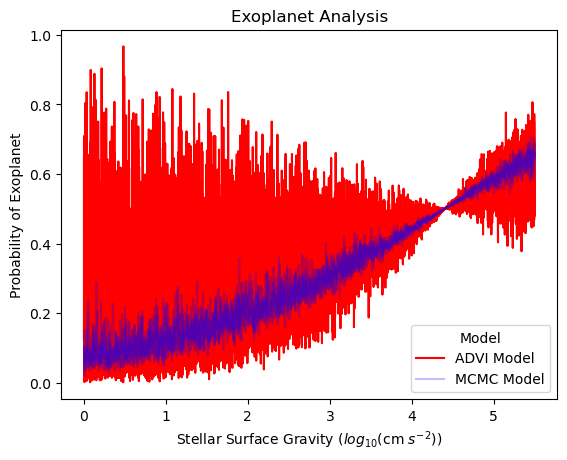

In [41]:
# Combined plot of the models
# models = ['main','simple']
colors = ['blue', 'green']
shape = binout.posterior['α'].shape
shape2 = advi_pp_trace.posterior['α'].shape
x = np.linspace(-10, 2.5, shape[1])
x = np.array(x)
x2 = np.linspace(-10, 2.5, shape2[1])
x2 = np.array(x2)
z = np.broadcast_to(x, shape)
z2 = np.broadcast_to(x2, shape2)
Age = np.linspace(0,5.5, shape[1])
Age2 = np.linspace(0,5.5, shape2[1])

main_post2 = 1/(1 + np.exp(-advi_pp_trace.posterior['β'][:,:,2]*z2))
out =[]
for i in range(1):
    out.append(main_post2[i,:])
    if i == 0:
        plt.plot(Age2,out[i], color = 'red', label = 'ADVI Model')
    else:
        plt.plot(Age2,out[i], color = 'red')

main_post = 1/(1 + np.exp(-binout.posterior['β'][:,:,2]*z))
out =[]
for i in range(4):
    out.append(main_post[i,:])
    if i == 0:
        plt.plot(Age,out[i], color = 'blue', label = 'MCMC Model', alpha = .25)
    else:
        plt.plot(Age,out[i], color = 'blue',alpha = .25)

plt.title("Exoplanet Analysis")
plt.xlabel("Stellar Surface Gravity ($log_{10}$(cm $s^{-2}$))")
plt.ylabel("Probability of Exoplanet")#, title="Binomial regression")
plt.legend(title ="Model")